In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None 
import numpy as np
import math as maths
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch
from matplotlib.patches import FancyArrow
import scipy.interpolate
import netCDF4 as nc
import xarray as xr
import scipy.ndimage
import scipy as sp
import alphashape
from numpy.linalg import eig
from matplotlib import ticker, cm
from scipy import interpolate
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from matplotlib import style
from pathlib import Path  
style.use('default') or plt.style.use('default')
import seaborn as sns


In [2]:
# Read in grounding line

dfGL = pd.read_csv("/Users/clara.henry/Documents/Derwael/Data/GroundingLine.csv")

points = np.column_stack((list(dfGL["Points:0"])[::10], list(dfGL["Points:1"])[::10]))

alpha = 0.95 * alphashape.optimizealpha(points)
hull = alphashape.alphashape(points, alpha)
hull_pts = hull.exterior.coords.xy

hull_pts = hull_pts

for i in range(len(hull_pts[0])):
    hull_pts[0][i] = hull_pts[0][i]/1000
    hull_pts[1][i] = hull_pts[1][i]/1000


/Users/clara.henry/opt/anaconda3/lib/python3.9/site-packages/shapely/ops.py:42: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  source = iter(source)
/Users/clara.henry/opt/anaconda3/lib/python3.9/site-packages/alphashape/optimizealpha.py:41: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  return all([polygon.intersects(point) for point in points])


In [3]:
# Read in stress and strain rate csv data

Sims = {'StrainStress_n3', 'StrainStress_n4'}

StrainStress_n3 = pd.read_csv('../Simulations/DerwaelSimulations/StrainRateStress/n3E0.5dsdt50StrainStress/StrainStress.csv', delimiter=',')
StrainStress_n4 = pd.read_csv('../Simulations/DerwaelSimulations/StrainRateStress/n4E1.8dsdt50StrainStress/StrainStress.csv', delimiter=',')


In [4]:
# Define functions to calculate horizontal velocity vectors

def normalise_vx(row):
    return row['velocity:0'] / (np.sqrt(row['velocity:0']**2 + row['velocity:1']**2))

def normalise_vy(row):
    return row['velocity:1'] / (np.sqrt(row['velocity:0']**2 + row['velocity:1']**2))


In [5]:
# Add new columns with the normalised velocity vectors

StrainStress_n3['vx_norm'] = StrainStress_n3.apply(lambda row: normalise_vx(row), axis=1)
StrainStress_n3['vy_norm'] = StrainStress_n3.apply(lambda row: normalise_vy(row), axis=1)
StrainStress_n4['vx_norm'] = StrainStress_n4.apply(lambda row: normalise_vx(row), axis=1)
StrainStress_n4['vy_norm'] = StrainStress_n4.apply(lambda row: normalise_vy(row), axis=1)


In [6]:
# Define a function for finding the angle between the velocity vector and the x-axis

def Angle(row):
    return maths.atan2(row['vy_norm'], row['vx_norm'])

# Apply to all rows in both dataframes

StrainStress_n3['vel angle'] = StrainStress_n3.apply(lambda row: Angle(row), axis=1)
StrainStress_n4['vel angle'] = StrainStress_n4.apply(lambda row: Angle(row), axis=1)


In [7]:
# Calculate the 2D rotated strain rate tensors

def ShearStrainRate(row):
    arr = np.array([[row['strainrate 1'], row['strainrate 4']], [row['strainrate 4'], row['strainrate 2']]])
    rot = np.array([[np.cos(row['vel angle']-np.pi/2.0), np.sin(row['vel angle']-np.pi/2.0)], [-np.sin(row['vel angle']-np.pi/2.0), np.cos(row['vel angle']-np.pi/2.0)]])
    arr_rot = np.matmul(np.matmul(rot, arr), rot.T)
    return arr_rot[1][0]

StrainStress_n3['shear strain rate vel'] = StrainStress_n3.apply(lambda row: ShearStrainRate(row), axis=1)  
StrainStress_n4['shear strain rate vel'] = StrainStress_n4.apply(lambda row: ShearStrainRate(row), axis=1)    



In [10]:
# Regrid the data 

vxRegridded = {}
vyRegridded = {}
SxxRegridded = {}
SyyRegridded = {}
SxyRegridded = {}
SyxRegridded = {}
ShearStrainRateRegridded = {}

xmin, xmax = min(StrainStress_n3['Points:0']), max(StrainStress_n3['Points:0'])
ymin, ymax = min(StrainStress_n4['Points:1']), max(StrainStress_n4['Points:1'])
dist = 100
nx, ny = int((xmax - xmin)/dist + 1), int((ymax - ymin)/dist + 1)
x = np.linspace(xmin, xmax, nx)
y = np.linspace(ymin, ymax, ny)
grid_x, grid_y = np.meshgrid(x, y)

vxRegridded[0] = scipy.interpolate.griddata((StrainStress_n3["Points:0"], StrainStress_n3["Points:1"]), StrainStress_n3["vx_norm"], (grid_x, grid_y), method='linear')
vyRegridded[0] = scipy.interpolate.griddata((StrainStress_n3["Points:0"], StrainStress_n3["Points:1"]), StrainStress_n3["vy_norm"], (grid_x, grid_y), method='linear')
SxxRegridded[0] = scipy.interpolate.griddata((StrainStress_n3["Points:0"], StrainStress_n3["Points:1"]), StrainStress_n3["strainrate 1"], (grid_x, grid_y), method='linear')
SyyRegridded[0] = scipy.interpolate.griddata((StrainStress_n3["Points:0"], StrainStress_n3["Points:1"]), StrainStress_n3["strainrate 2"], (grid_x, grid_y), method='linear')
SxyRegridded[0] = scipy.interpolate.griddata((StrainStress_n3["Points:0"], StrainStress_n3["Points:1"]), StrainStress_n3["strainrate 4"], (grid_x, grid_y), method='linear')
ShearStrainRateRegridded[0] = scipy.interpolate.griddata((StrainStress_n3["Points:0"], StrainStress_n3["Points:1"]), StrainStress_n3["shear strain rate vel"], (grid_x, grid_y), method='linear')
vxRegridded[1] = scipy.interpolate.griddata((StrainStress_n4["Points:0"], StrainStress_n4["Points:1"]), StrainStress_n4["vx_norm"], (grid_x, grid_y), method='linear')
vyRegridded[1] = scipy.interpolate.griddata((StrainStress_n4["Points:0"], StrainStress_n4["Points:1"]), StrainStress_n4["vy_norm"], (grid_x, grid_y), method='linear')
SxxRegridded[1] = scipy.interpolate.griddata((StrainStress_n4["Points:0"], StrainStress_n4["Points:1"]), StrainStress_n4["strainrate 1"], (grid_x, grid_y), method='linear')
SyyRegridded[1] = scipy.interpolate.griddata((StrainStress_n4["Points:0"], StrainStress_n4["Points:1"]), StrainStress_n4["strainrate 2"], (grid_x, grid_y), method='linear')
SxyRegridded[1] = scipy.interpolate.griddata((StrainStress_n4["Points:0"], StrainStress_n4["Points:1"]), StrainStress_n4["strainrate 4"], (grid_x, grid_y), method='linear')
ShearStrainRateRegridded[1] = scipy.interpolate.griddata((StrainStress_n4["Points:0"], StrainStress_n4["Points:1"]), StrainStress_n4["shear strain rate vel"], (grid_x, grid_y), method='linear')


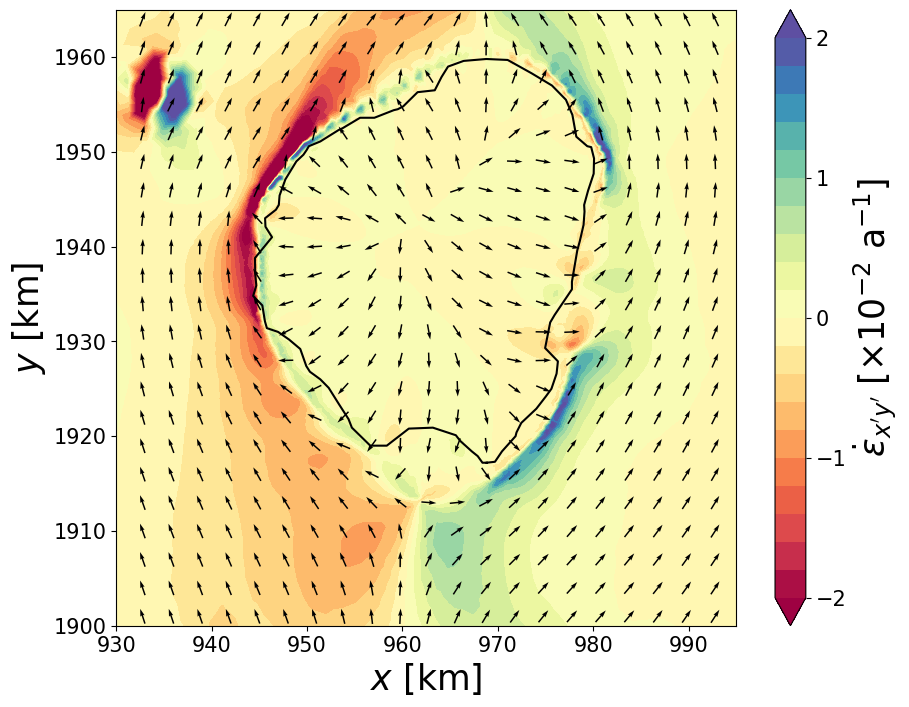

In [11]:
# Plot the shear strain rate for n=3

inter = 30
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
CS = ax.contourf(x/1000, y/1000, ShearStrainRateRegridded[0]*100, levels=np.linspace(-2,2,21),  cmap="Spectral", extend = 'both')
skip = (slice(None, None, inter), slice(None, None, inter))
ax.quiver(x[::inter]/1000, y[::inter]/1000, vxRegridded[0][skip], vyRegridded[0][skip], scale=40, pivot='mid')
ax.set_xlabel(r'$x$ [km]', size=25)
ax.set_ylabel(r'$y$ [km]', size=25)
ax.plot(hull_pts[0], hull_pts[1], color='black')
ax.tick_params(axis='both', which='major', labelsize=15)
plt.xlim(930, 995)
plt.ylim(1900, 1965)
cbar = fig.colorbar(CS, ticks=[-2.0, -1.0, 0.0, 1.0, 2.0])
cbar.ax.tick_params(labelsize=15)
cbar.set_label(r"$\dot{\epsilon}_{x'y'}$ [$\times 10^{-2}$ a$^{-1}$]", rotation=90, size=25)

fig.savefig('../Figures/ShearStrainRaten3.jpg', format='jpg', dpi=700, bbox_inches = "tight")


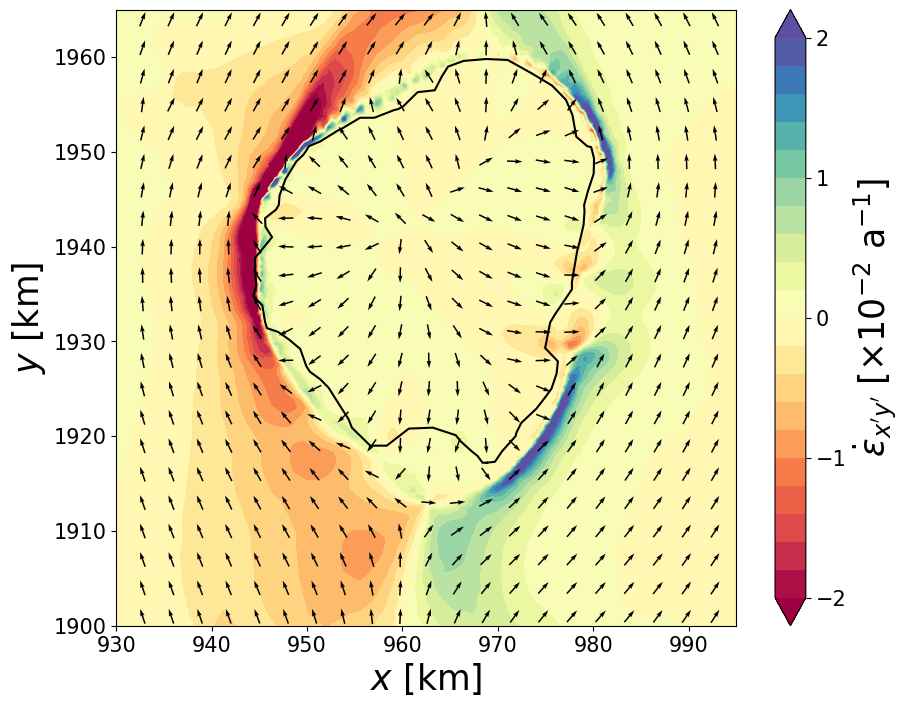

In [12]:
# Plot the shear strain rate for n=4

inter = 30
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
CS = ax.contourf(x/1000, y/1000, ShearStrainRateRegridded[1]*100, levels=np.linspace(-2,2,21),  cmap="Spectral", extend = 'both')
skip = (slice(None, None, inter), slice(None, None, inter))
ax.quiver(x[::inter]/1000, y[::inter]/1000, vxRegridded[0][skip], vyRegridded[0][skip], scale=40, pivot='mid')
ax.set_xlabel(r'$x$ [km]', size=25)
ax.set_ylabel(r'$y$ [km]', size=25)
ax.plot(hull_pts[0], hull_pts[1], color='black')
ax.tick_params(axis='both', which='major', labelsize=15)
plt.xlim(930, 995)
plt.ylim(1900, 1965)
cbar = fig.colorbar(CS, ticks=[-2.0, -1.0, 0.0, 1.0, 2.0])
cbar.ax.tick_params(labelsize=15)
cbar.set_label(r"$\dot{\epsilon}_{x'y'}$ [$\times 10^{-2}$ a$^{-1}$]", rotation=90, size=25)

fig.savefig('../Figures/ShearStrainRaten4.jpg', format='jpg', dpi=700, bbox_inches = "tight")


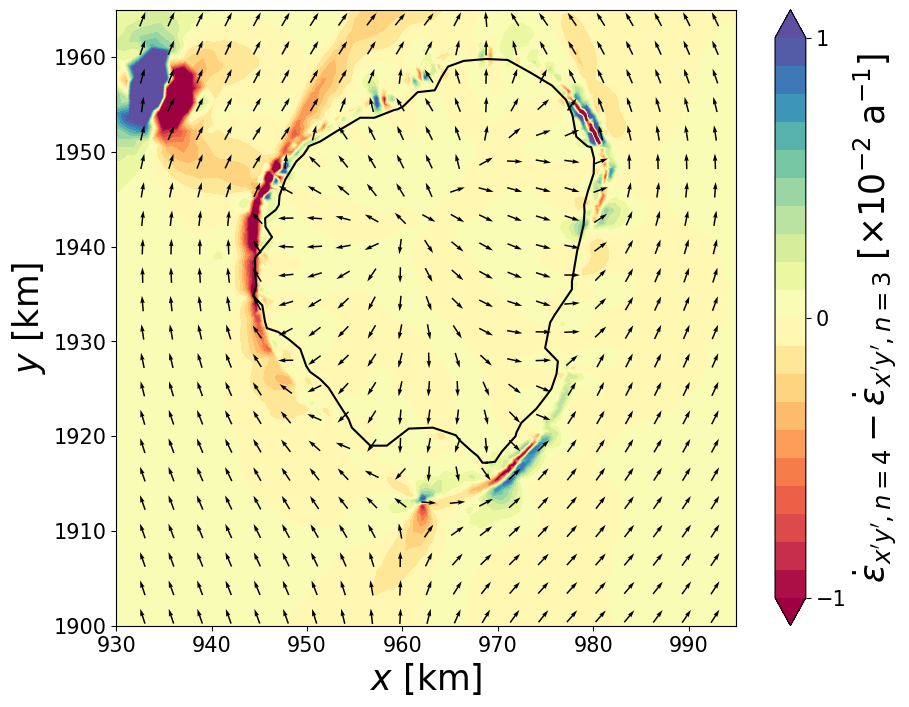

In [13]:
# Plot the difference between the shear strain rate for n=4 and n=3

inter = 30
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
CS = ax.contourf(x/1000, y/1000, (ShearStrainRateRegridded[1]-ShearStrainRateRegridded[0])*100, levels=np.linspace(-1,1,21),  cmap="Spectral", extend = 'both')
#CS = ax.contourf(x/1000, y/1000, 200*np.divide((ShearStrainRateRegridded[1]-ShearStrainRateRegridded[0]),(ShearStrainRateRegridded[1]+ShearStrainRateRegridded[0])), levels=np.linspace(-100,100,21),  cmap="Spectral", extend = 'both')
skip = (slice(None, None, inter), slice(None, None, inter))
ax.quiver(x[::inter]/1000, y[::inter]/1000, vxRegridded[0][skip], vyRegridded[0][skip], scale=40, pivot='mid')
ax.set_xlabel(r'$x$ [km]', size=25)
ax.set_ylabel(r'$y$ [km]', size=25)
ax.plot(hull_pts[0], hull_pts[1], color='black')
ax.tick_params(axis='both', which='major', labelsize=15)
plt.xlim(930, 995)
plt.ylim(1900, 1965)
#cbar = fig.colorbar(CS, ticks=[-1, -0.5, 0.0, 0.5, 1])
cbar = fig.colorbar(CS, ticks=[-1, 0.0, 1])
cbar.ax.tick_params(labelsize=15)
cbar.set_label(r"$\dot{\epsilon}_{x'y',n=4} - \dot{\epsilon}_{x'y',n=3}$ [$\times 10^{-2}$ a$^{-1}$]", rotation=90, size=25)

fig.savefig('../Figures/ShearStrainRateDiffn4_n3.jpg', format='jpg', dpi=700, bbox_inches = "tight")


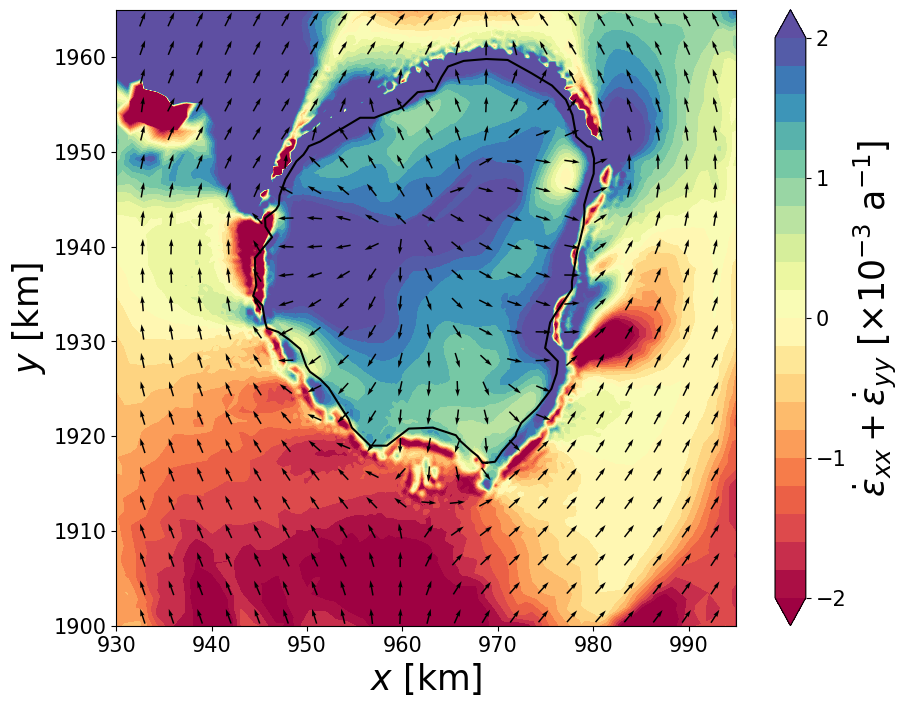

In [14]:
# Plot the horizontal dilation / divergence for n=3

inter = 30
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
CS = ax.contourf(x/1000, y/1000, (SxxRegridded[0] + SyyRegridded[0])*1000, levels=np.linspace(-2,2,21),  cmap="Spectral", extend = 'both')
skip = (slice(None, None, inter), slice(None, None, inter))
ax.quiver(x[::inter]/1000, y[::inter]/1000, vxRegridded[0][skip], vyRegridded[0][skip], scale=40, pivot='mid')
ax.set_xlabel(r'$x$ [km]', size=25)
ax.set_ylabel(r'$y$ [km]', size=25)
ax.plot(hull_pts[0], hull_pts[1], color='black')
ax.tick_params(axis='both', which='major', labelsize=15)
plt.xlim(930, 995)
plt.ylim(1900, 1965)
cbar = fig.colorbar(CS, ticks=[-2, -1, 0.0, 1, 2])
cbar.ax.tick_params(labelsize=15)
cbar.set_label(r"$\dot{\epsilon}_{xx} + \dot{\epsilon}_{yy}$ [$\times 10^{-3}$ a$^{-1}$]", rotation=90, size=25)

fig.savefig('../Figures/Dilation_n3.jpg', format='jpg', dpi=700, bbox_inches = "tight")



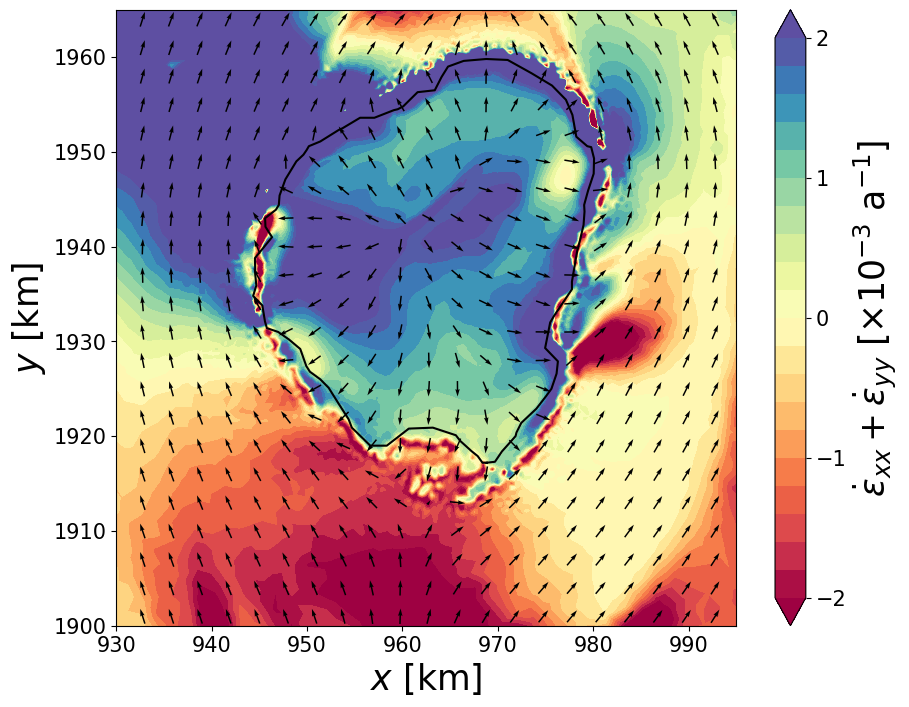

In [15]:
# Plot the horizontal dilation / divergence for n=4

inter = 30
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
CS = ax.contourf(x/1000, y/1000, (SxxRegridded[1] + SyyRegridded[1])*1000, levels=np.linspace(-2,2,21),  cmap="Spectral", extend = 'both')
skip = (slice(None, None, inter), slice(None, None, inter))
ax.quiver(x[::inter]/1000, y[::inter]/1000, vxRegridded[1][skip], vyRegridded[1][skip], scale=40, pivot='mid')
ax.set_xlabel(r'$x$ [km]', size=25)
ax.set_ylabel(r'$y$ [km]', size=25)
ax.plot(hull_pts[0], hull_pts[1], color='black')
ax.tick_params(axis='both', which='major', labelsize=15)
plt.xlim(930, 995)
plt.ylim(1900, 1965)
cbar = fig.colorbar(CS, ticks=[-2.0, -1.0, 0.0, 1.0, 2.0])
cbar.ax.tick_params(labelsize=15)
cbar.set_label(r"$\dot{\epsilon}_{xx} + \dot{\epsilon}_{yy}$ [$\times 10^{-3}$ a$^{-1}$]", rotation=90, size=25)

fig.savefig('../Figures/Dilation_n4.jpg', format='jpg', dpi=700, bbox_inches = "tight")


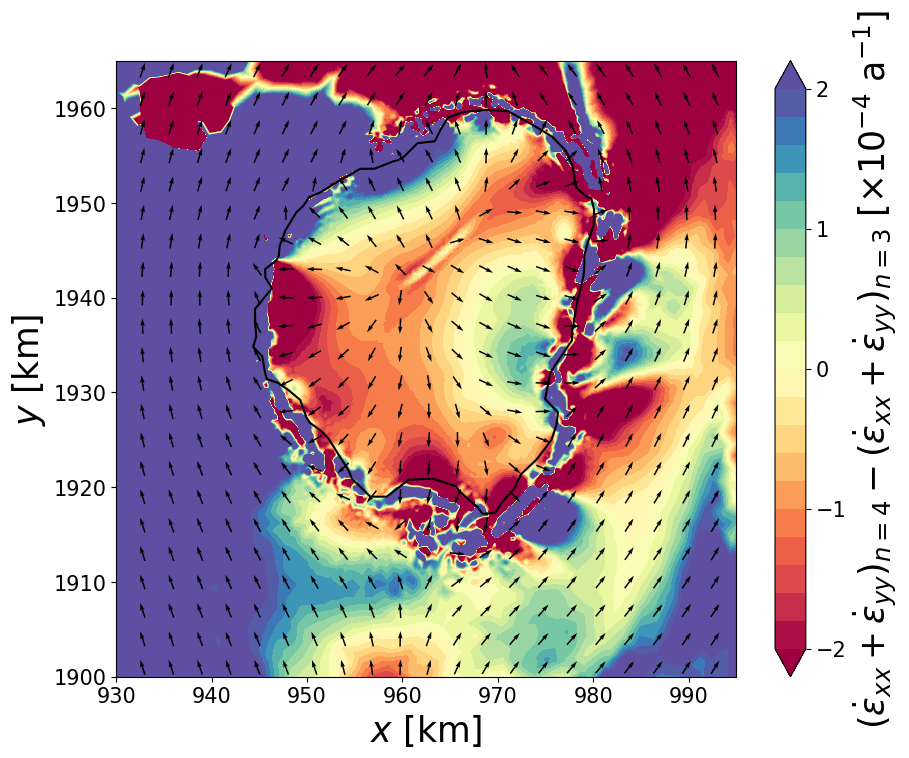

In [16]:
# Plot the difference between the horizontal dilation / divergence for n=4 and n=3

inter = 30
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
CS = ax.contourf(x/1000, y/1000, (SxxRegridded[1] + SyyRegridded[1] - (SxxRegridded[0] + SyyRegridded[0]))*10000, levels=np.linspace(-2,2,21),  cmap="Spectral", extend = 'both')
skip = (slice(None, None, inter), slice(None, None, inter))
ax.quiver(x[::inter]/1000, y[::inter]/1000, vxRegridded[1][skip], vyRegridded[1][skip], scale=40, pivot='mid')
ax.set_xlabel(r'$x$ [km]', size=25)
ax.set_ylabel(r'$y$ [km]', size=25)
ax.plot(hull_pts[0], hull_pts[1], color='black')
ax.tick_params(axis='both', which='major', labelsize=15)
plt.xlim(930, 995)
plt.ylim(1900, 1965)
cbar = fig.colorbar(CS, ticks=[-2.0, -1.0, 0.0, 1.0, 2.0])
cbar.ax.tick_params(labelsize=15)
cbar.set_label(r"$(\dot{\epsilon}_{xx} + \dot{\epsilon}_{yy})_{n=4} - (\dot{\epsilon}_{xx} + \dot{\epsilon}_{yy})_{n=3}$ [$\times 10^{-4}$ a$^{-1}$]", rotation=90, size=25)

fig.savefig('../Figures/DilationDiff_n4_n3_Rise.jpg', format='jpg', dpi=700, bbox_inches = "tight")


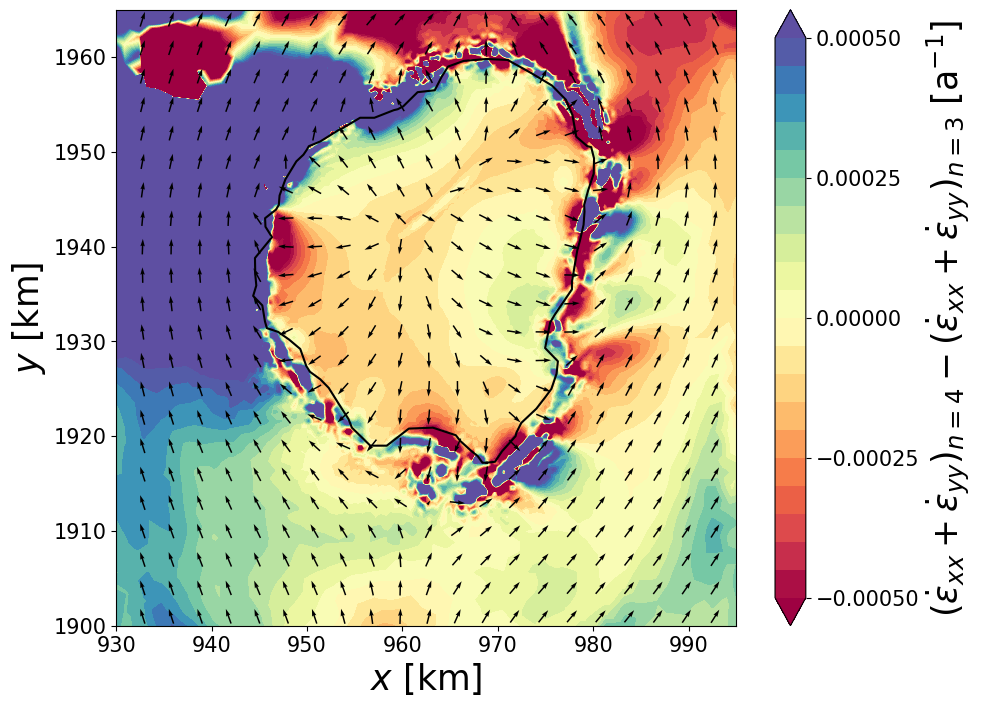

In [17]:
# Plot the difference between the horizontal dilation / divergence for n=4 and n=3

inter = 30
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
CS = ax.contourf(x/1000, y/1000, SxxRegridded[1] + SyyRegridded[1] - (SxxRegridded[0] + SyyRegridded[0]), levels=np.linspace(-0.0005,0.0005,21),  cmap="Spectral", extend = 'both')
skip = (slice(None, None, inter), slice(None, None, inter))
ax.quiver(x[::inter]/1000, y[::inter]/1000, vxRegridded[1][skip], vyRegridded[1][skip], scale=40, pivot='mid')
ax.set_xlabel(r'$x$ [km]', size=25)
ax.set_ylabel(r'$y$ [km]', size=25)
ax.plot(hull_pts[0], hull_pts[1], color='black')
ax.tick_params(axis='both', which='major', labelsize=15)
plt.xlim(930, 995)
plt.ylim(1900, 1965)
cbar = fig.colorbar(CS, ticks=[-0.0005, -0.00025, 0.0, 0.00025, 0.0005])
cbar.ax.tick_params(labelsize=15)
cbar.set_label("$(\dot{\epsilon}_{xx} + \dot{\epsilon}_{yy})_{n=4} - (\dot{\epsilon}_{xx} + \dot{\epsilon}_{yy})_{n=3}$ [a$^{-1}$]", rotation=90, size=25)

fig.savefig('../Figures/DilationDiff_n4_n3_Shelf.jpg', format='jpg', dpi=700, bbox_inches = "tight")
